In [1]:
import tensorflow as tf
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
tf.config.experimental_run_functions_eagerly(True)
import numpy as np
import random
import matplotlib.pyplot as plt
########################################
########################################
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
tf.config.experimental_run_functions_eagerly(True)
GPU_OPTIONS = tf.compat.v1.GPUOptions(allow_growth=True)
SESS = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=GPU_OPTIONS))
# cudnn may brings deviation in the final indexes even if the random seed has been fixed
########################################
########################################
from tensorflow import keras
from utils import get_id_label, DECTGenerator
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

2024-12-16 16:23:59.862696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


2024-12-16 16:24:03.381694: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-16 16:24:03.383146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-16 16:24:05.225416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2024-12-16 16:24:05.225576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-12-16 16:24:05.240659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-12-16 16:24:05.240710: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.s

In [2]:
pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6 = [], [], [], [], [], [], []
true_2 = []

model_shallow = '/data1/jianghai/DECT/code/tfversion/checkpoint/20240305_142448_fold_1_best_model'
model_shallow_se = '/data1/jianghai/DECT/code/tfversion/checkpoint/20240305_142510_fold_1_best_model'
model_proposed = '/data1/jianghai/DECT/code/tfversion/checkpoint/20241215_114620_fold_1_best_model'

model_vgg16 = '/data1/jianghai/DECT/code/tfversion/checkpoint/20240305_142812_fold_1_best_model'
model_vgg19 = '/data1/jianghai/DECT/code/tfversion/checkpoint/20240305_143116_fold_1_best_model'
model_resnet = '/data1/jianghai/DECT/code/tfversion/checkpoint/20240305_143239_fold_1_best_model'
model_dense = '/data1/jianghai/DECT/code/tfversion/checkpoint/20240305_143313_fold_1_best_model'

model_single = '/data1/jianghai/DECT/code/tfversion/checkpoint/20241214_210859_fold_1_best_model'
model_single_vc = '/data1/jianghai/DECT/code/tfversion/checkpoint/20241214_210937_fold_1_best_model'

In [16]:
NUM_CLASSES = 3
BATCH_SIZE = 32
ROOT_PATH = '/data1/jianghai/DECT/'
test_txt = ROOT_PATH + 'txt/multi/multi_test.txt'
test_id_list, test_label_list = get_id_label(test_txt)

test_dataset = DECTGenerator(IDs_list=test_id_list, label_list=test_label_list, 
                             num_classes=NUM_CLASSES, batch_size=16, shuffle=False, 
                             n_channels=11, #energy_level=0, 
                             augmentation=None)

loss_object = keras.losses.CategoricalCrossentropy(from_logits=True)
test_accuracy = keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_auc = keras.metrics.AUC(name='test_auc',  thresholds=np.arange(0,1+0.000001,0.000001))
test_loss = keras.metrics.Mean(name='test_loss', dtype=tf.float32)
# print(len(model_name))
# for n in model_name:
#     print(model_name.index(n))

In [17]:
gt, pre = [], []
model = tf.keras.models.load_model(model_shallow_se)
for test_array, test_labels in test_dataset:
    predictions = model(test_array, False)#, None
    loss = loss_object(test_labels, predictions)

    test_loss(loss)
    test_accuracy(test_labels, predictions)
    # preds = tf.nn.softmax(predictions)
    test_auc(test_labels, tf.nn.softmax(predictions))
    
    for t in test_labels.tolist():#tf.nn.softmax(test_labels):
        # true.append(np.argmax(t))
        gt.append(t)
    for p in predictions.numpy().tolist():#tf.nn.softmax(predictions):
        # pred.append(np.argmax(p))
        pre.append(p)
    # print(true)
# print(pred)
# true = np.array(gt)
true_2 = np.array(gt)
pred_2 = np.array(pre)
print(test_auc.result())

tf.Tensor(0.75439453, shape=(), dtype=float32)


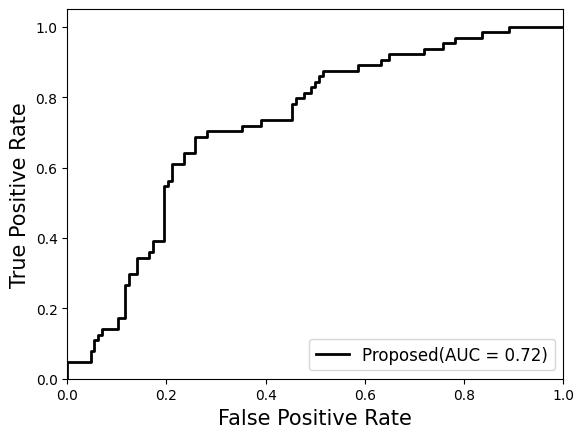

In [18]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

n_classes = [0, 1, 2]
y_test = true_2
y_score = pred_2
label_name = 'Proposed'
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in n_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"], 
            label=label_name + '(AUC = {0:0.2f})'''.format(roc_auc["micro"]), color='black', 
            linestyle='-', 
            linewidth=2)

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize=12)
# plt.show()
# plt.savefig('fold 2.eps', format='eps', dpi=400)
plt.show()

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
# y_test = true
# y_score = pred_1
score_array = [pred_0, pred_1, pred_3, pred_4, pred_5, pred_6]
color_array = ['orange', 'yellow', 'green', 'blue', 'gray', 'purple']
name_array = ['Shallow', 'Shallow+SE', 'VGG16', 'VGG19', 'ResNet', 'DenseNet121']
# for s in score_array:
# y_test = true
# y_score = pred
n_classes=[0, 1, 2]
# FPR, TPR, ROC_AUC = [dict(), dict(), dict(), dict(), dict(), dict()], [dict(), dict(), dict(), dict(), dict(), dict()], [dict(), dict(), dict(), dict(), dict(), dict()]
# i = 0
# for s in score_array:
for j in range(6):
# if score_array.index(s) == 2:
#     y_test = true_2
#     n_classes = [0, 1, 2, 3]
    # print(i)
    y_test = np.array(true)
    y_score = np.array(score_array[j])
    # plt.style.use('default')
    # Plot linewidth.
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in n_classes:
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    label_name = name_array[j]
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    # all_fpr = np.unique(np.concatenate([fpr[i] for i in n_classes]))
    # # Then interpolate all ROC curves at this points
    # mean_tpr = np.zeros_like(all_fpr)
    # for i in n_classes:
    #     mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # # Finally average it and compute AUC
    # mean_tpr /= len(n_classes)
    # fpr["macro"] = all_fpr
    # tpr["macro"] = mean_tpr
    # roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    # plt.figure(1)
    # label = score_array[i]
    plt.plot(fpr["micro"], tpr["micro"], 
             label=label_name + '(AUC = {0:0.2f})'''.format(roc_auc["micro"]), 
             linestyle='-', 
             linewidth=1)
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(n_classes, colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
n_classes = [0, 1, 2, 3]
y_test = true_2
y_score = pred_2
label_name = 'Proposed'
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in n_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"], 
            label=label_name + '(AUC = {0:0.2f})'''.format(roc_auc["micro"]), color='black', 
            linestyle='-', 
            linewidth=2)

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize=12)
# plt.show()
plt.savefig('fold 2.eps', format='eps', dpi=400)
plt.show()

In [ ]:
print(y_test.shape, y_score.shape)

In [ ]:
plt.savefig('fold 3.eps', format='eps', dpi=300)
plt.show()

In [ ]:
for s in name_array:
    print(type(s))

In [ ]:

txt_path = '/data1/jianghai/DECT/txt/multi/multi_test.txt'
id, label = [], []
f = open(txt_path, 'r')
for line in f:
    id.append(line.split()[0])
    label.append(line.split()[1])

print(label.count('0'), label.count('1'), label.count('2'))